### 研究動機：特斯拉主題分類以及預測銷售量任務
工具：
+ week4 情緒分析(CKIP)
+ week5 情緒分析(SnowNLP), NFR、
+ Week6 Bigram, TD-IDF、
+ Week7 模型與分類器訓練
+ Week10 LDA
+ Week11 字與字得關聯, Transform model(like bert but Decoder-only), Embedding分類任務
+ Week12 bert(encoder-only-model)

資料來源：
+ 資料來源：PPT車版
+ 關鍵字：特斯拉、Tesla、馬斯克、Musk
+ 訓練資料日期：2023/1/1 - 2023/12/31
+ 新資料日期：202/1/1 - 2024/3/31

可能的分析方向：
+ 社群媒體分析：探索特斯拉在不同社群媒體平台上的評論和討論。如特斯拉的技術創新、環保意識等。
+ 市場趨勢預測：分析特斯拉的新產品發布、重大事件或競爭對手的動態對市場的影響，並進行股市趨勢預測。
+ 產品品質分析：使分析消費者的投訴、讚美和建議，並進行情緒分類和主題分析，探討產品品質的缺點與優點。
+ 競爭分析：分析特斯拉與其他競爭對手的比較。特斯拉和其他汽車品牌的情緒和評價，了解特斯拉市場上的定位和競爭策略。

以產品品質分析+市場趨勢(銷量)分析為例：
+ 分析過程：1. 透過Guide-LDA做主題分類，將特斯拉主題試著分類(客訴、開箱、事故、車禍、品質等)並產生主題標籤。
+ 分析過程：2. 將文章做情緒分析(SnowNLP)，分析負面與正面原因
+ 分析過程：3. n-gram捕捉特斯拉產品相關的常用詞彙、計算字與字的關聯度分數
+ 分析過程：4. 加入新文章，分別使用embedding/DTM 搭配 分類器模型來分類新文章，順便看哪個效果較好
+ 分析過程：5. 以季度為單為，透過情緒分析來預測汽車銷量(需要用到回歸模型 但課程沒教)

問題：
+ 透過非監督式學習LDA的分類後產生標籤，再將標籤後的文章透過embedding+分類訓練器，將後續匯入的新文章賦予標籤這件事情是否合理？ 會不會新文章直接丟進去LDA效果更好？LDA是否也有fine-tune 就不需要重跑一次
+ 好東西都在"artComment"但課程好像沒有去解析artComment欄位，都是針對artContent去分析，這個部分可以保留未來執行

In [19]:
import time 
import pandas as pd #pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
import numpy as np #numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
import re #re: 正規表達式套件。
import math #math: 數學運算工具。
import datetime
from pprint import pprint

import seaborn as sns
from matplotlib import font_manager
import matplotlib.pyplot as plt  #matplotlib: 繪圖工具。

import jieba #jieba: 中文斷詞套件。
import jieba.analyse

import pyLDAvis
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import guidedlda

from wordcloud import WordCloud 
from nltk import ngrams, FreqDist #NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
from collections import Counter, namedtuple #collections: 提供額外的數據類型。
import networkx as nx #networkx: 網絡圖建構、繪製工具。
from snownlp import SnowNLP #SnowNLP 針對中文設計，可以提取句子的情緒分類
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)

In [23]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] #金萱粉圓體2.0
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] 

# 設定文字雲中文字體路徑 金萱粉圓體2.0
FontPath = 'path/to/jf-openhuninn-2.0.ttf' # 設定字型
# FontPath = './SourceHanSansTW-Regular.otf' # 設定字型

plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

# Path to the custom font
font_path = 'font/jf-openhuninn-2.0.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break


Found font: jf-openhuninn-2.0


In [30]:
#匯入資料
df = pd.read_csv('./data/PTT_Tesla_2023.csv', encoding = 'UTF-8')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
df = df[['artDate','artTitle','artContent']]
df['artDate'] = pd.to_datetime(df['artDate'])
df.head(3)

,artDate,artTitle,artContent
0,2023-01-01 10:48:19,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....
1,2023-01-01 22:42:25,[問題]特斯拉久了會掉電嗎？,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...
2,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,原文連結：\nhttps://star.setn.com/news/1232578?utm_...


In [95]:
MetaData = df.copy()
MetaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
#MetaData['artDate'] =  pd.to_datetime(MetaData['artDate']).dt.to_period('D')

# 只留下中文字
MetaData['artContent'] = MetaData['artContent'].str.replace("(http|https)://.*", "", regex=True)
MetaData['artTitle'] = MetaData['artTitle'].str.replace("(http|https)://.*", "", regex=True)
MetaData['artContent'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['artTitle'] = MetaData['artTitle'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))


MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['sentence'] = MetaData['sentence'].apply(lambda x: re.sub('[口]', '', x))

MetaData.head(3)

,artDate,artTitle,artContent,sentence
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...


In [96]:
raw_data = MetaData.copy()
raw_data['content'] = raw_data['artContent']
raw_data = raw_data.loc[:,["artDate", "content", ]]  # 文章內容 文章連結
raw_data.head(3)

,artDate,content
0,2023-01-01 10:48:19,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,2023-01-01 22:42:25,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...
2,2023-01-02 12:47:31,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...


In [41]:
missing_values = raw_data[raw_data["content"].isnull()]
print("具有缺失值的行：")
print(missing_values)

具有缺失值的行：
Empty DataFrame
Columns: [artDate, content]
Index: []


In [43]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")
#jieba.load_userdict('./dict/BBWord.txt')

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [44]:
raw_data["words"] = raw_data["content"].apply(getToken)
raw_data.head()

Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/Final project/SMA_project/林憲聰/dict/dict.txt ...
Loading model from cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.u5cb9e61a7df0c42f03459705e0d7cd98.cache
Loading model cost 0.209 seconds.
Prefix dict has been built successfully.


,artDate,content,words
0,2023-01-01,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"[八卦, 官網, 特斯拉, 二手車, 三方, 平台, 便宜, 黨會, 勝利]"
1,2023-01-01,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"[前輩, 中古, 特斯拉, 里程, 擔心, 電池, 電越, 充越, 少電, 里程數, 越少開..."
2,2023-01-02,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"[原文, 連結, 原文, 內容, 王家, 徐兆緯, 台北, 電競, 世界, 冠軍, 日前, ..."
3,2023-01-02,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"[如題, 特斯拉, 最近, 出門, 車位, 很煩, 騎家裡, 超舊, 機車, 機車道, 機車..."
4,2023-01-02,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"[原文, 連結, 原文, 內容, 美國, 汽車, 召回, 排名, 揭曉, 超過, 萬輛車, ..."


In [45]:
docs = raw_data['words'].to_list()
docs[0]

['八卦', '官網', '特斯拉', '二手車', '三方', '平台', '便宜', '黨會', '勝利']

In [46]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

Dictionary<4208 unique tokens: ['三方', '二手車', '便宜', '八卦', '勝利']...>


In [47]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

三方: 0
二手車: 1
便宜: 2
八卦: 3
勝利: 4
官網: 5
平台: 6
特斯拉: 7
一點: 8
中古: 9
之後: 10
公里: 11


In [48]:
print(" ".join(raw_data['words'].iloc[600]))

預算 車庫 雲嘉 透天 保養 方便 車格 老闆 開缺 車頭 換車 新世代 科技感 保養 稅金 新時代 產品 年輕 缺怕 遠門 麻煩 充電 麻煩 大車 車格 有什麼 建議


In [49]:
dictionary.doc2bow(raw_data['words'].iloc[600])[:10]

[(16, 1),
 (436, 1),
 (739, 1),
 (784, 1),
 (1012, 1),
 (1019, 1),
 (1035, 2),
 (1040, 1),
 (1158, 1),
 (1333, 1)]

In [50]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [51]:
type(corpus)

list

In [65]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=2024, # 亂數
)

In [66]:
ldamodel.print_topics()

[(0,
  '0.022*"特斯拉" + 0.016*"電動車" + 0.009*"汽車" + 0.009*"駕駛" + 0.007*"台灣" + 0.007*"原文" + 0.006*"中國" + 0.006*"公司" + 0.006*"充電" + 0.005*"電池"'),
 (1,
  '0.017*"特斯拉" + 0.015*"電動車" + 0.014*"充電" + 0.011*"汽車" + 0.008*"原文" + 0.007*"品牌" + 0.006*"中國" + 0.006*"市場" + 0.005*"車主" + 0.005*"心得"'),
 (2,
  '0.023*"特斯拉" + 0.012*"汽車" + 0.010*"充電" + 0.009*"駕駛" + 0.008*"中國" + 0.008*"電池" + 0.008*"車主" + 0.008*"電動車" + 0.006*"台灣" + 0.005*"自動"'),
 (3,
  '0.026*"特斯拉" + 0.014*"電動車" + 0.007*"汽車" + 0.006*"充電" + 0.006*"車主" + 0.005*"目前" + 0.005*"問題" + 0.005*"時間" + 0.005*"使用" + 0.005*"電池"')]

In [54]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

-8.087786123755786

In [55]:
np.exp2(-perplexity)

272.06095723061634

In [56]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

這個主題的 PMI score:  -0.01776247127539309


In [57]:
NPMI_model_lda.get_coherence_per_topic()

[-0.025156501014519408,
 0.005088602444711236,
 -0.02084688998679331,
 -0.060908827465433836,
 -0.040438112299768625,
 -0.029386574023147937,
 -0.008307761271819755,
 0.008311477344749034,
 0.004916772851970725,
 -0.011004924096241124,
 -0.012239772370383982,
 -0.019175260719483302,
 -0.03559880706223035,
 -0.02128999907308152,
 -0.0004004923894241417]

In [58]:
t0 = time.time()

topic_num_list = np.arange(2, 14)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 53.971620082855225 sec

花費時間: 53.971620082855225 sec


<Axes: xlabel='topic_num'>

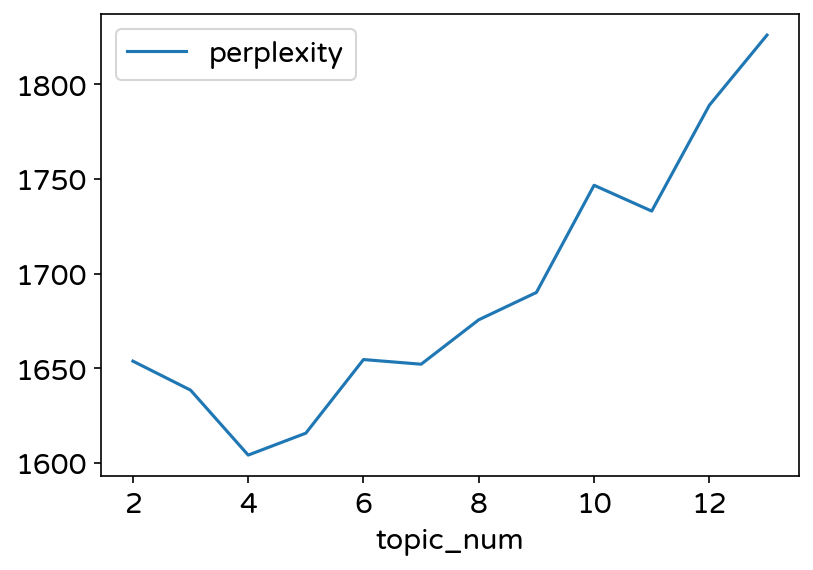

In [59]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

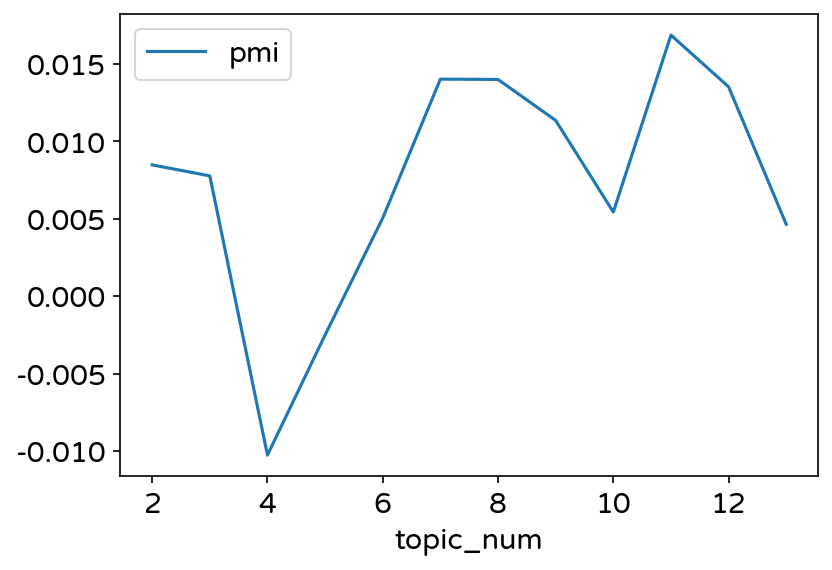

In [60]:
result.plot.line(x='topic_num', y='pmi')

In [67]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 11,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

In [68]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.046062 -0.007794       1        1  18.137136
5     -0.161056  0.014037       2        1  14.554097
1      0.154234 -0.058403       3        1  13.697932
7      0.014608  0.060424       4        1  11.245423
10     0.086298  0.167170       5        1   8.268782
0     -0.129069 -0.063167       6        1   8.181665
2     -0.090968 -0.026045       7        1   8.081039
9     -0.023829 -0.002508       8        1   6.002127
8      0.132168 -0.103944       9        1   4.997370
6     -0.041288  0.014511      10        1   4.375209
3      0.012840  0.005719      11        1   2.459219, topic_info=    Term         Freq        Total Category  logprob  loglift
436   充電  1215.000000  1215.000000  Default  30.0000  30.0000
366   中國   777.000000   777.000000  Default  29.0000  29.0000
27   電動車  1680.000000  1680.000000  Default  28.0000  28.0000
148   汽車  1279.000000  1279.000000  Default  27.0000  27.0000
7    特斯拉  2916.000000  2916.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
134   品牌    12.276500   511.357704  Topic11  -5.5721  -0.0241
156   美國    11.918556   497.711156  Topic11  -5.6017  -0.0266
98    連結    11.141150   421.985889  Topic11  -5.6691   0.0710
354   這種    10.694808   236.824598  Topic11  -5.7100   0.6078
94    說明    10.850472   356.477657  Topic11  -5.6956   0.2133

[796 rows x 6 columns], token_table=      Topic      Freq Term
term                      
29        1  0.278139   一下
29        2  0.018139   一下
29        3  0.371859   一下
29        4  0.105814   一下
29        5  0.009070   一下
...     ...       ...  ...
4131      9  0.791067  高雄場
2728      5  0.052867  高雄市
2728      9  0.845879  高雄市
1048      1  0.769918   麗寶
1048     11  0.085546   麗寶

[3300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 2, 8, 11, 1, 3, 10, 9, 7, 4])

In [62]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('三方', '二手車', '便宜', '八卦', '勝利', '官網', '平台', '特斯拉', '一點', '中古')

In [63]:
word2id = dictionary.token2id

In [ ]:
seed_topic_list = [
    [],
    [],
    []
]

In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

In [ ]:
model = guidedlda.GuidedLDA(n_topics=4, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

In [99]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

In [100]:
topics_doc[100]

[(1, 0.9797915)]

In [101]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.01010535, 0.01010956, 0.01010565, ..., 0.01010563, 0.01010581,
        0.01010646],
       [0.        , 0.42413273, 0.        , ..., 0.08165735, 0.        ,
        0.46822137],
       [0.        , 0.12763712, 0.05206794, ..., 0.        , 0.        ,
        0.42289191],
       ...,
       [0.        , 0.90907121, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03000482, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.99707663, 0.        ,
        0.        ]])

In [102]:
raw_data['topic_label'] = m_theta.argmax(axis=1) + 1

In [103]:
raw_data['topic_label'].value_counts()

topic_label
5     267
2     172
11    133
8     132
6     125
3      98
1      85
10     68
7      51
4      50
9      42
Name: count, dtype: int64

In [104]:
raw_data.head()

,artDate,content,topic_label
0,2023-01-01 10:48:19,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,6
1,2023-01-01 22:42:25,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,11
2,2023-01-02 12:47:31,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,11
3,2023-01-02 18:01:04,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,9
4,2023-01-02 19:21:24,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,3


In [105]:
raw_data['artDate'] = pd.to_datetime(raw_data['artDate'])

In [106]:
raw_data.groupby(raw_data['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2023-01-01  11             0.500000
            6              0.500000
2023-01-02  1              0.250000
            9              0.250000
            11             0.250000
                             ...   
2023-12-30  2              0.500000
            11             0.166667
            8              0.166667
            6              0.166667
2023-12-31  9              1.000000
Name: proportion, Length: 909, dtype: float64

In [107]:
date_topic = raw_data.groupby(raw_data['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5,6,7,8,9,10,11
artDate,,,,,,,,,,,
2023-01-01,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,0.50
2023-01-02,0.25,NaN,0.250000,NaN,NaN,NaN,NaN,NaN,0.25,NaN,0.25
2023-01-03,NaN,NaN,0.333333,NaN,0.333333,0.333333,NaN,NaN,NaN,NaN,NaN
2023-01-04,NaN,0.2,NaN,0.4,NaN,NaN,NaN,NaN,NaN,0.20,0.20
2023-01-06,NaN,NaN,NaN,NaN,NaN,0.750000,NaN,NaN,NaN,0.25,NaN


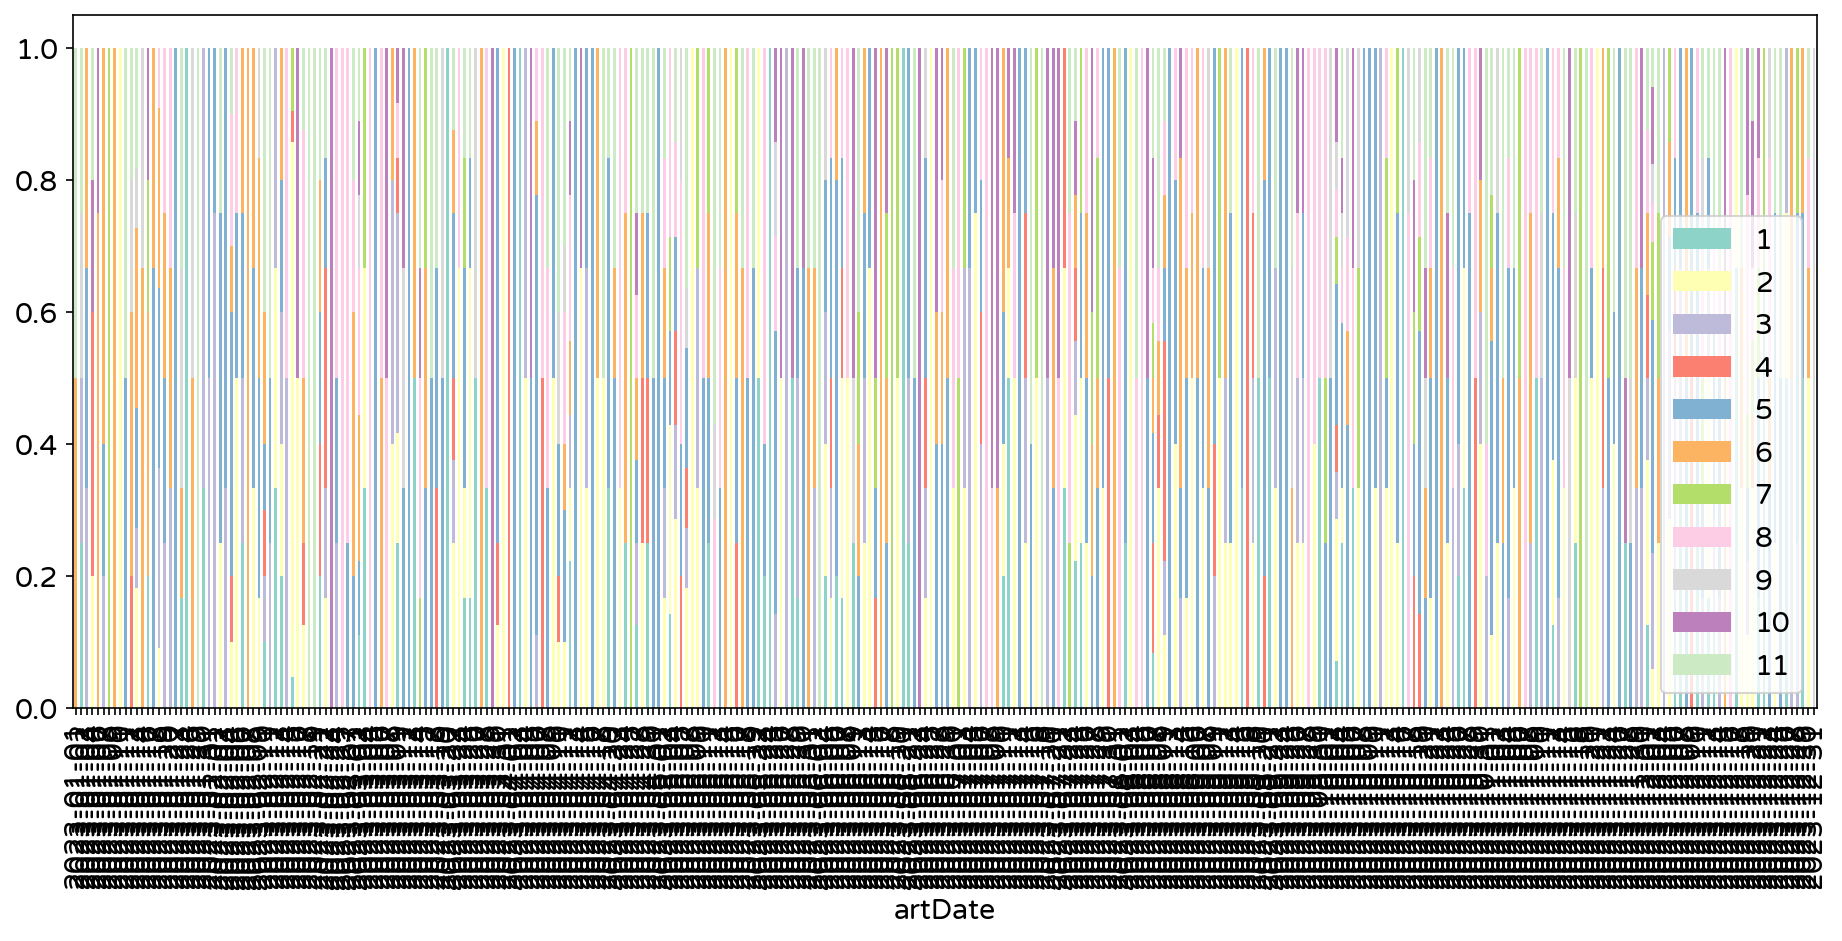

In [108]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

In [109]:
raw_data

,artDate,content,topic_label
0,2023-01-01 10:48:19,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,6
1,2023-01-01 22:42:25,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,11
2,2023-01-02 12:47:31,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,11
3,2023-01-02 18:01:04,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,9
4,2023-01-02 19:21:24,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,3
...,...,...,...
1218,2023-12-30 13:22:05,特斯拉超充要花費的成本是最低的因為土地地主要無償提供給特斯拉電車網紅有訪問過超充地主你說連地...,11
1219,2023-12-30 16:47:46,最近特斯拉新更新把輔助駕駛搭配車內鏡頭變得更嚴格總之會偵測你眼睛有沒有在看前方或者是不是在睡...,2
1220,2023-12-30 17:44:17,好有共鳴雖然我不是小眼睛但我是斜視看前面就像吉娃娃的眼睛也是一直被警告後來我把內鏡頭貼起來就...,2
1221,2023-12-30 21:39:18,心得特斯拉也太不衛生了吧這是最低兩百萬最高到四五百萬的豪車耶怎可以有床蝨這種髒東西還整船被澳...,6


In [115]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

,artDate,artTitle,artContent,sentence,word
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,官網
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,特斯拉


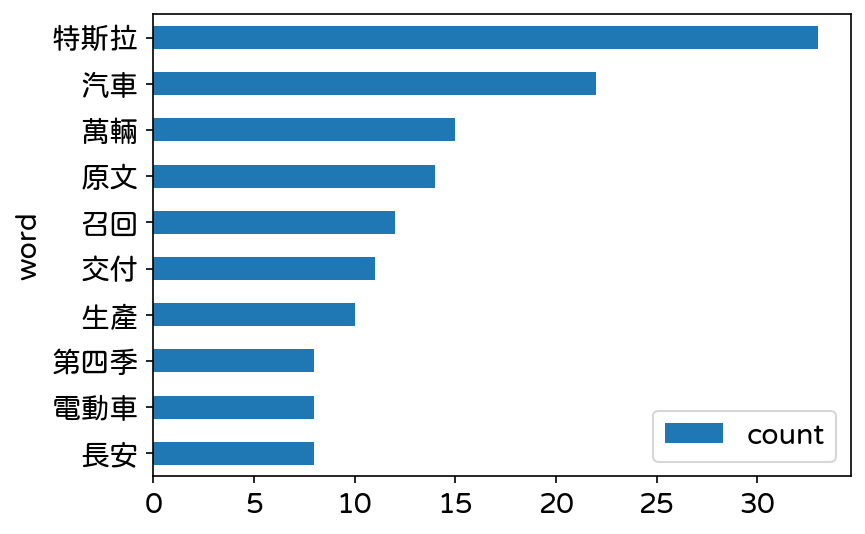

In [116]:
barplot_data = pd.DataFrame(pd.value_counts(data['word'])).reset_index()
barplot_data.columns = ['word','count']
barplot_data = barplot_data.sort_values(by = 'count', ascending = False).reset_index(drop = True)
#barplot_data.to_csv("barplot_data.csv", index=False)
barplot_data.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

In [117]:
#新增停用字
stopWords_manual = ["來源","市場","排行","大神","目前","是不是","也將","紅包","通知","讀版","圖片","以下","需要","連結","記者","署名","發文","發布","時間",
                    "心得","評論","正文","張數","原文","標題","網址","內文","口","張數","家數","年月日","單位","統計","證券","名稱","交易所","代號","謝謝",
                    "分類","標的","報導","格式", "股票名稱", "業者","依板", "版規", "刪除", "內容", "未依", "規處份", "輸入", "文處份", "處份", "股號",
                    "板規", "股名", "類免","第四季", "原文", "萬輛"]
stopWords.extend(stopWords_manual)

# 重新去除停用字
data['word'] = data.sentence.apply(getToken).explode('word')

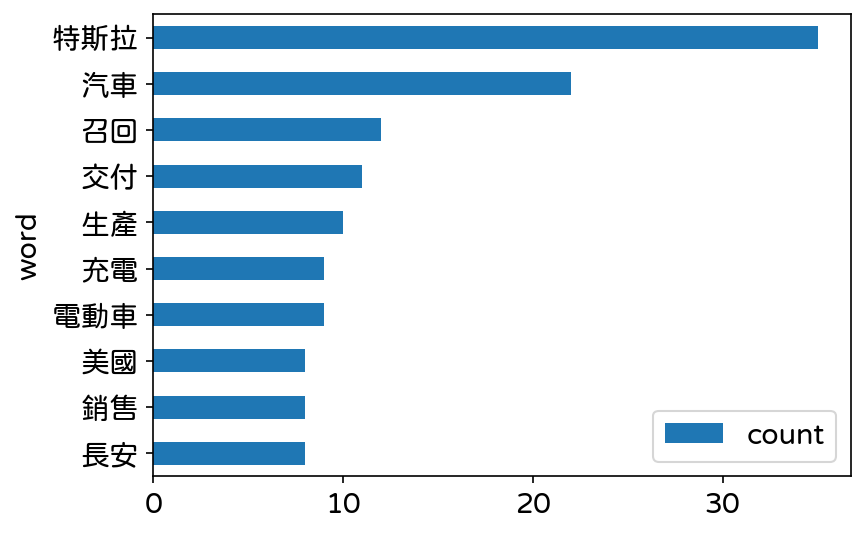

In [118]:
barplot_data = pd.DataFrame(pd.value_counts(data['word'])).reset_index()
barplot_data.columns = ['word','count']
barplot_data = barplot_data.sort_values(by = 'count', ascending = False).reset_index(drop = True)
#barplot_data.to_csv("barplot_data.csv", index=False)
barplot_data.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()